In [123]:
# Run this code to unzip the Skin Diseases Data into a "dataset" folder
import zipfile as zf
files = zf.ZipFile("archive.zip", 'r')
files.extractall('dataset')
files.close()

In [175]:
# Useful Imports
import torch 
import torch.nn as nn
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score

In [89]:
# Converts every image to 256x256 dimension, randomly change images for generalization,
# into a tensor, normalize pixel values
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Converts every image to 256x256 dimension and into a Tensor
val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loads each subset directory from your "dataset" folder
train_dataset = datasets.ImageFolder(root='dataset/Train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=val_test_transform)
val_dataset = datasets.ImageFolder(root='dataset/Val', transform=val_test_transform)

# Hyper Parameters for dataset organization and processing
batch_size = 100
num_workers = 3
# Dataloader for each subset which will batch, shuffle, and parallel load the data
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [90]:
# Total images in each subset
print('Train data: ', len(train_dataset))
print('Test data: ', len(test_dataset))
print('Valid data: ', len(val_dataset))

Train data:  1198
Test data:  389
Valid data:  250


torch.Size([3, 128, 128])
tensor(3)
torch.Size([100, 3, 128, 128])
torch.Size([100])


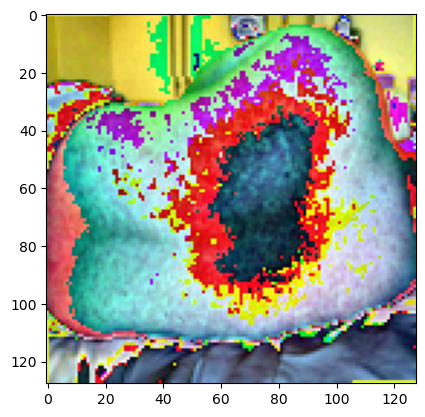

In [91]:
# Check a batch of data
images, labels = next(iter(train_dataloader))

print(images[0].size()) # Number of Colors (RGB=3), Height=256, Width=256
print(labels[0]) # Herpes=0, Melanoma=1, Monkeypox=2, Sarampion=3, Varicela=4
print(images.shape)
print(labels.shape)

# Will show the image sampled
image = transforms.ToPILImage()(images[0])
plt.imshow(image)
plt.show()

In [92]:
# Calculates output layer size, convenient when making multiple hidden layers
image_size = 29
kernel_size = 3
padding = 0
stride = 1
pool = 3

output_shape = np.floor((((image_size - kernel_size + (2 * padding)) / stride) + 1) / pool)
print(output_shape)

9.0


In [162]:
# Custom CNN Model

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0), # Output Layer = 126
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2)) # Output Layer = 62

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=0), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2)) # Output Layer = 29

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=3, stride=3)) # Output Layer = 9
        
        self.fc1 = nn.Sequential(
            nn.Linear(256*9*9, 128),
            nn.ReLU())

        self.fc2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU())
        
        self.fc3 = nn.Linear(64, 5)

    def forward(self, out):
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.view(-1, 256*9*9)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [163]:
# Allows model to run on GPU if it is present
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [164]:
# Test run, should output torch.Size([batch_size, classes])
custom_cnn = CustomCNN().to(device)
output = custom_cnn(images.to(device))
print(output.size())

torch.Size([100, 5])


In [165]:
# Declare Model
custom_cnn = CustomCNN().to(device)

# Set Hyper Parameters
epochs = 25
learning_rate = 0.001

# Declare Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_cnn.parameters(), lr = learning_rate)

In [166]:
# Train the model
total_step = len(train_dataloader)
for epoch in range(epochs):
    #loss_per_epoch = 0
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = custom_cnn(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #loss_per_epoch += loss.item()
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, epochs, i+1, total_step, loss.item()))
    #print(f"Epoch: {epoch}, {loss_per_epoch/total_step}")

Epoch [1/25], Step [1/12], Loss: 1.6246
Epoch [1/25], Step [2/12], Loss: 2.0450
Epoch [1/25], Step [3/12], Loss: 4.1091
Epoch [1/25], Step [4/12], Loss: 3.0556
Epoch [1/25], Step [5/12], Loss: 2.1322
Epoch [1/25], Step [6/12], Loss: 1.7141
Epoch [1/25], Step [7/12], Loss: 1.4223
Epoch [1/25], Step [8/12], Loss: 1.5943
Epoch [1/25], Step [9/12], Loss: 1.3778
Epoch [1/25], Step [10/12], Loss: 1.4693
Epoch [1/25], Step [11/12], Loss: 1.4488
Epoch [1/25], Step [12/12], Loss: 1.2584
Epoch [2/25], Step [1/12], Loss: 1.1032
Epoch [2/25], Step [2/12], Loss: 1.0556
Epoch [2/25], Step [3/12], Loss: 1.1588
Epoch [2/25], Step [4/12], Loss: 1.3047
Epoch [2/25], Step [5/12], Loss: 1.1489
Epoch [2/25], Step [6/12], Loss: 1.1833
Epoch [2/25], Step [7/12], Loss: 1.0264
Epoch [2/25], Step [8/12], Loss: 1.3013
Epoch [2/25], Step [9/12], Loss: 1.2018
Epoch [2/25], Step [10/12], Loss: 1.1602
Epoch [2/25], Step [11/12], Loss: 1.0158
Epoch [2/25], Step [12/12], Loss: 1.1231
Epoch [3/25], Step [1/12], Loss: 1

In [171]:
# Define a calculate_accuracy function
def calculate_accuracy(model, dataloader, device):
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
    
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
    
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')

In [172]:
# Calculate validation accuracy of model
calculate_accuracy(custom_cnn, val_dataloader, device)

Accuracy: 53.2%


In [173]:
# Produces a confusion matrix, and metrics including Precision, Recall, and F1 Score
def confusion_matrix_and_metrics(model, dataloader, device):
    model.eval()
    
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues", 
        xticklabels=dataloader.dataset.classes, 
        yticklabels=dataloader.dataset.classes)
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Precision of the MLP :\t"+str(precision_score(y_true, y_pred, average="macro")))
    print("Recall of the MLP    :\t"+str(recall_score(y_true, y_pred, average="macro")))
    print("F1 Score of the Model :\t"+str(f1_score(y_true, y_pred, average="macro")))

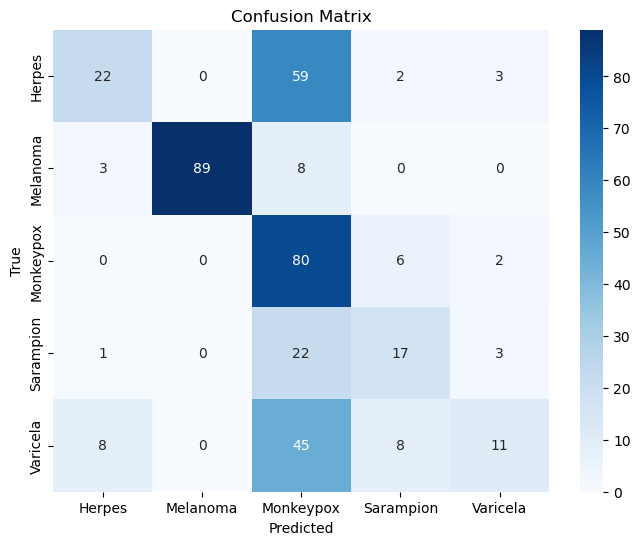

Precision of the MLP :	0.6229978965605828
Recall of the MLP    :	0.5206062955132722
F1 Score of the Model :	0.5054787191559587


In [174]:
# Test code for above function
confusion_matrix_and_metrics(custom_cnn, test_dataloader, device)

In [ ]:
# Implementation of Bayesian Optimization to improve Hyper Parameters

# Representation of how our model is changed
def objective(params):
    lr = params[0]
    batch_size = int(params[1])
    dropout = params[2]